# Noiseless Sparse Reconstruction
In this notebook we will review a few "easy-to-implent" Compressed Sensing (CS) reconstruction methods. The goal is to familiarize the reader with a few different techniques to gain an intuition of how these reconstruction approaches operate and help alleviate the "black-magic" view of CS reconstruction.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import sklearn.linear_model as lm
import scipy.linalg as la
import pywt as pw
from DepsRecon import *
from scipy.stats import lomax

Before we can start to review any CS signal reconstruction, we first require a signal to reconstruct! We will generate a target $K$-Sparse signal synthetically. We'll then take some measurements of this signal and from those measurements attempt to recover the original. Since we have an original target to compare to, this is often called a "planted" problem.

We'll start by creating a function to generate a random orthonormal basis, $F$. Orthonormal, here, means that the basis vectors of $F$ are independent from one another and, additionally, that each of these vectors is normalized such that they have an $\ell_2$ norm of 1.

In [2]:
def RandomOrthoProjection(M,N):
    """ Create a random orthonormal projection matrix.
    
        Inputs
        ------
        M: int
           Number of rows in the matrix.
        N: int
           Number of columns in the matrix.
           
        Returns
        -------
        F: array_like, float
           The random orthonormal matrix
    """
    
    F = np.random.randn(M,N)   # Generate the random samples
    F = la.orth(F.T).T         # Perform orthogonalization (Basis for Span(F))
    
    return F

Next, we'll create particular realizations of our signal and projection matrix.

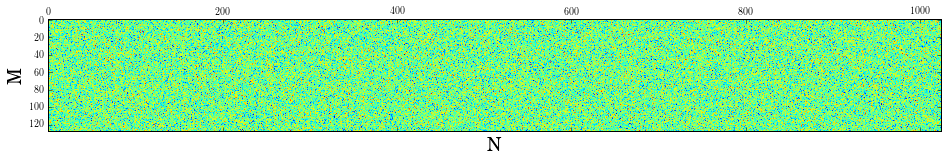

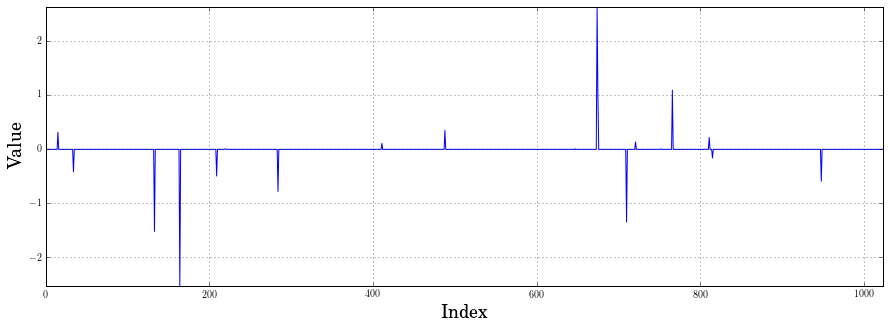

In [3]:
N = 1024      # Signal Dimensionality
M = 128       # Number of measurements
K = 20        # Number of non-zeros
x,xs = RandomKSparseSignal(K,N)
F = RandomOrthoProjection(M,N)

ShowProjection(F)
ShowSignal(x)

Now, given $F$ and the true $x$, lets calculate the value of the observations for this planted problem. We accomplish this through the simple matrix multiplication,
$$ y = F x$$

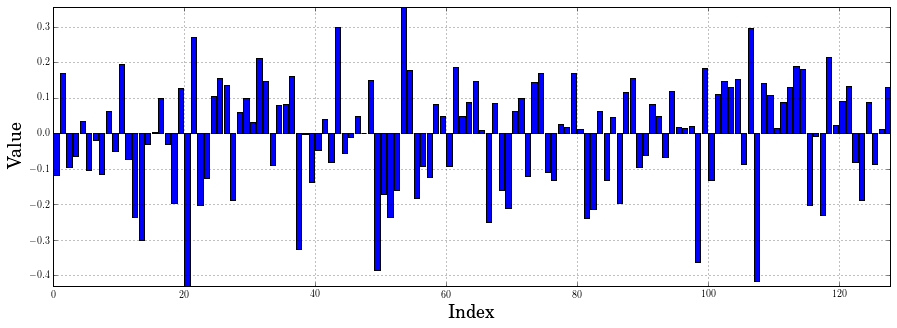

In [4]:
y = np.dot(F,x)
ShowMeasurements(y)

Our goal then is to find some reconstruction $\hat{x}$, which should be close to $x$, using only the observations $y$ and the projection matrix $F$. The first thing that one might attempt to do is to find the Least-Squares solution to this problem. As we saw in lecture, we cannot say that this solution will be anything at all like our original one, since there is an entire space of possible $\hat{x}$ which all map to the same $y$ in this case of under-sampling, $M<N$.

We can calculate the least-squares solution by using the Pseudo-Inverse of the matrix $F$,

$$\hat{x} = F^{\dagger} y = (F^T F)^{-1} F^T y$$.

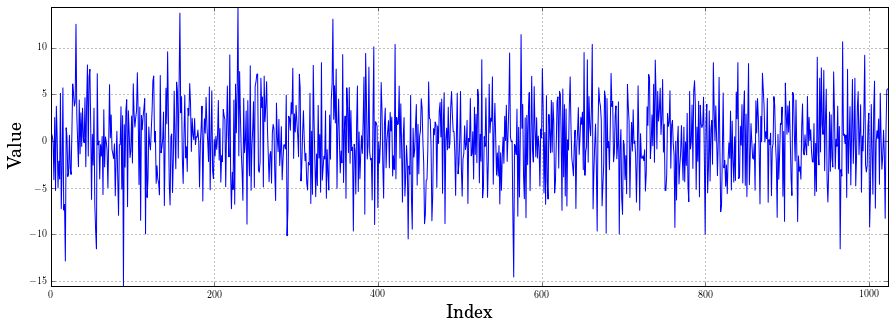

In [5]:
FtF = np.dot(F.T,F)           # Calculate $(F^T F)$
Fty = np.dot(F.T,y)           # Calculate $F^T y$
xlsq = la.solve(FtF,Fty)      # Invert FtF and multiply against Fty

ShowSignal(xlsq)

We can see that this signal is nowhere near to the original one. However, as we mentioned in lecture, this signal does indeed match our observations, since it is one of the many vectors which lie in the space of possible solutions.

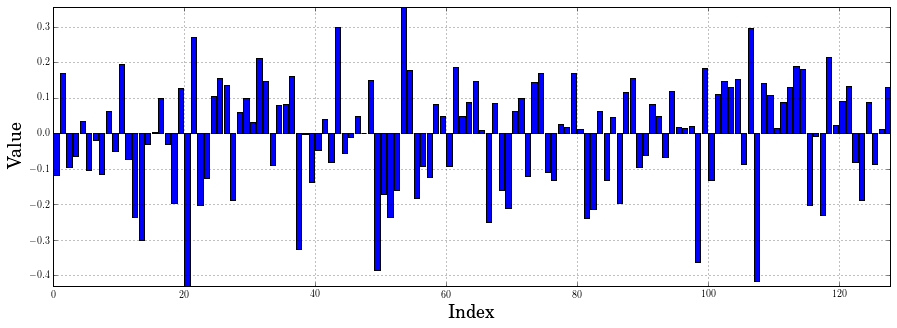

In [6]:
ShowMeasurements(np.dot(F,xlsq))

Now, as mentioned earlier, one the of the easiest approaches to regularization is *Ridge Regression* or *Tikhonov Regularization*. Here, we will regularize the least-squares problem by solving instead
$$\arg \min_{x}\quad||y - Fx||_2^2 + \lambda ||x||_2.$$

This problem can be solved directly via
$$\hat{x} = (F^T F + \lambda I)^{-1} F^T y.$$

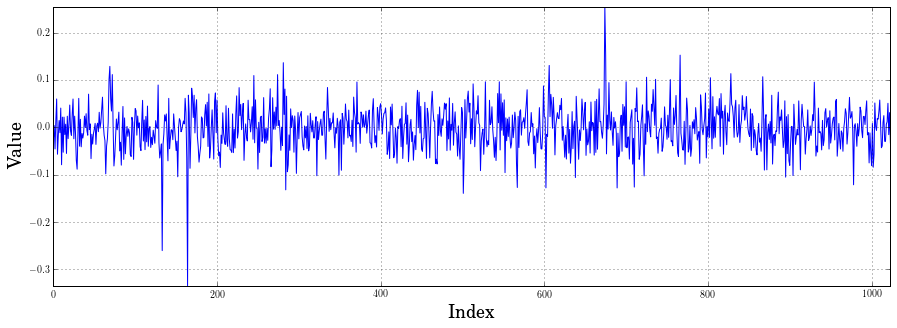

In [7]:
lam = 0.2
FtFI = FtF + lam * np.eye(np.shape(F)[1])

xtik = la.solve(FtFI,Fty)
ShowSignal(xtik)

So, we see that the $\ell_2$ regularized solution is more correlated with our original signal, however, it still suffers from a lot of noise on what should be the non-zero values. This is because the $\ell_2$ norm does not promote trunction to 0 for these small values.

## Iterative Hard Thresholding (IHT)
---
One of the easiest-to-implement algorithms for CS reconstruction is iterative hard thresholding. The IHT approach seeks to solve the following problem,
$$\arg\min_x\quad ||y-Fx||_2^2\quad s.t.\quad||x||_0 = K.$$

The IHT tackles this non-convex problem by iteratively bouncing between the space of satisfying solutions and the space of $K$-sparse signals. This sounds a bit complicated at first, but as we will see, this is really quite a simple procedure. In essence, the entire algorithm can be written in the following equation,

$$ x^{(t+1)} =  H_K\left(x^{(t)} + F^T(y - Fx^{(t)}) \right),$$

where $x^{(t)}$ refers to the approximation of the original signal at iteration $t$ and the operator $H_K(\cdot)$ refers to a thresholding of all but the $K$ largest magnitude coefficients.

---
- T. Blumensath & M. E. Davies, "Iterative Thresholding for Sparse Approximations," _Journal of Fourier Analysis and Applications_, vol. 14, no. 5, pg. 629-654, 2008.
- T. Blumensath & M. E. Davies, "Iterative Hard Thresholding for Comrpessed Sensing," _Applied and Computational Harmonic Analysis_, vol. 27, no. 3, pg. 265-274, 2009.


In [8]:
def IterativeHardThresholding(F,y,K,iters,xtrue):
    """ Use the IHT alorithm to reconstruct a sparse signal.
    
        Attempt to solve the inverse problem
        
                    y = F x
        
        for known y, F, and unknown K-sparse x.
                
    
        Inputs
        -----
        F: array_like, float
           An (M,N) projection matrix
        y: array_like, float
           A vector of observations
        K: int
           Number of non-zeros in the recovered signal.
        iters: int
               Number of iterations to run for.
               
        Returns
        -------
        x: array_like, float
           Recovered K-sparse signal
        mseval: array_like, float
                The MSE against ``xtrue`` at each iteration
        resval: array_like, float
                The MSE between ``y`` and the estimate ``F x`` at each
                iteration.
    """
    m,n = np.shape(F)                        # Find the dimensions of the problem
    x = np.zeros((n,1))                      # Initial solution for ``x``, the starting point
    mseval = np.zeros((iters,1))             # Initialize array for MSE values
    resval = np.zeros((iters,1))             # Initialize array for Residual values
    
    for t in range(0,iters):                 # Loop over the number of iterations
        ## Update Approximation
        r = y - np.dot(F,x)                  # Find the gradient in Real^M, (y - F x)
        z = x + np.dot(F.T,r)                # Take a step in Real^N by projecting gradient
        x = KSparseApproximation(z,K)[0]     # Threshold the new value of x  
        ## Measure Progress
        mseval[t]   = MeanSquareError(xtrue,x) # Calculate how far from the true solution we are
        resval[t] = MeanSquareError(y,np.dot(F,x)) # Calculate how far from the measurements we are
        
    return x,mseval,resval        

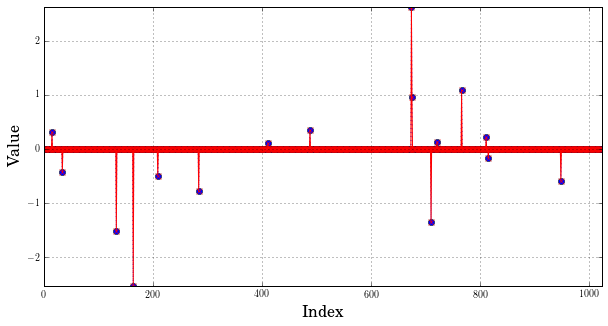

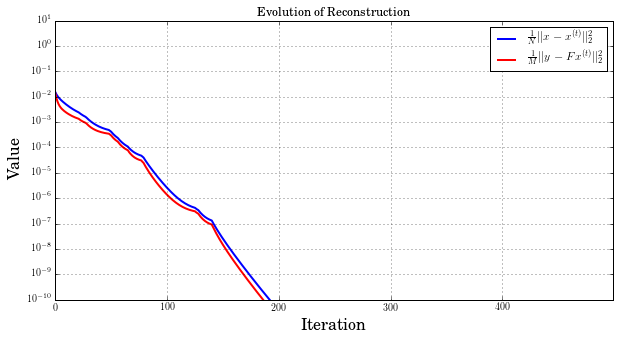

In [9]:
xiht,ihtmse,ihtres = IterativeHardThresholding(F,y,K,500,x)

ShowRecovery(x,xiht)
ShowHistory(ihtmse,ihtres)

## Orthogonal Matching Pursuit (OMP)
---
For orthogonal matching pursuit, one is also attempting to solve the reconstruction problem of the form
$$\arg\min_x\quad ||y-Fx||_2^2\quad s.t.\quad||x||_0 = K.$$

However, instead of an iteration based on bouncing between spaces, lets instead take a more support-oriented approach. OMP is an iterative algorithm, meaning that the approximation successively improves over multiple passes, however, the manner in which we do this is different than the IHT. Instead of attempting to locate **all** $K$ significant coefficients at **each** iteration, we will instead have each iteration _refine_ our estimation of the support.

E.g. on each iteration (or pass) we will simply attempt to identify **one** element of the support, including this in a running list of support values. After we have completed $K$ passes, we will have identified up to $K$ support locations. The refinement is accomplished by looking at the difference $r^{(t)} = y - F x^{(t)}$ at each pass and seeing which column of $F$ is most correlated with this difference. The *most* correlated column is therefore the support-location which will move us the furthest towards the solution space and should therefore be included in the support list, $S^{(t)}$.

Subsequently, we refine $r^{(t)}$ by finding the LSQ solution of the on-support (or sub-) problem, $F_S x_S = y$, which is an overdetermined. Finally, we update $r^{(t+1)} = y - F_S x_S$ and begin again.

---
- J. Tropp and A. Gilbert, "Signal Recovery from Random Measurements via Orthogonal Matching Pursuit," _IEEE Transactions on Information Theory_, vol. 53, no. 12, pg. 4655-4666, 2007.

In [10]:
def OrthogonalMatchingPursuit(F,y,K,xtrue):
    """ Use the OMP alorithm to reconstruct a sparse signal.
    
        Attempt to solve the inverse problem
        
                    y = F x
        
        for known y, F, and unknown K-sparse x.
                
    
        Inputs
        -----
        F: array_like, float
           An (M,N) projection matrix
        y: array_like, float
           A vector of observations
        K: int
           Number of non-zeros in the recovered signal.
        xtrue: array_like, float
               Original signal, used to track MSE progress
               
        Returns
        -------
        x: array_like, float
           Recovered K-sparse signal
        Support: array_like, int
                List of support locations
        mseval: array_like, float
                The MSE against ``xtrue`` at each iteration
        resval: array_like, float
                The MSE between ``y`` and the estimate ``F x`` at each
                iteration.        
    """
    m,n = np.shape(F)                    # Find problem dimensions
    Support = np.empty((0,1),dtype=int)  # Initialize list of support
    r = y                                # Intialize ``r`` to ``y``
    Fs = []                              # Initial sub-matrix is empty
    mseval = np.zeros((K,1))             # Initialize array for MSE values
    resval = np.zeros((K,1))             # Initialize array for Residual values
    
    ## Main Loop
    for t in range(1,K+1):
        ## Find most correlated column
        response = np.abs(np.dot(F.T,r))              # Calculate the correlations between
                                                      #   the columns of F and r.
        maxcorrcol = response.argmax()                # Index of the maximum correlation
        Support = np.append(Support,maxcorrcol)       # Add this index to the support list
        Support = np.unique(Support)                  # Remove duplicate entries from the support list
        NS = np.size(Support)                         # Record the number of on-support coefficients
        ## Construct on-support sub-matrix 
        Fs = F[:,Support.astype(int)]                 # Sub-sample the columns of F according to the support list
        Fs = np.reshape(Fs,(m,NS))                    # Ensure that A is in the right data-type (safety)
        ## Solve LSQ for on-support sub-problem
        if NS>1:
            xs = la.lstsq(Fs,y)[0]                    # Solve A x = y using Least Squares
        else:
            # In the case that ``A`` consists of a single column,
            # ``scipy.linalg`` will not allow us to use the ``lstsq``
            # function. So, we perform a linear regression to find
            # the best-fitting coefficient.
            xs = lm.LinearRegression().fit(Fs,y).coef_[0]
        ## Update residual
        r = np.reshape(r,(m,1))                         # Ensure that r is in the data-type (safety)
        r  = y - np.reshape(np.dot(Fs,xs),(m,1))        # Update r, ensure that A
        ## Measure Progress
        x = np.zeros((n,1))                             # Make a full version of x
        x[Support] = xs                                 # Assign on-support coefficients
        mseval[t-1]   = MeanSquareError(xtrue,x)        # Calculate how far from the true solution we are
        resval[t-1] = MeanSquareError(y,np.dot(F,x))    # Calculate how far from the measurements we are
        
    return x, Support, mseval, resval

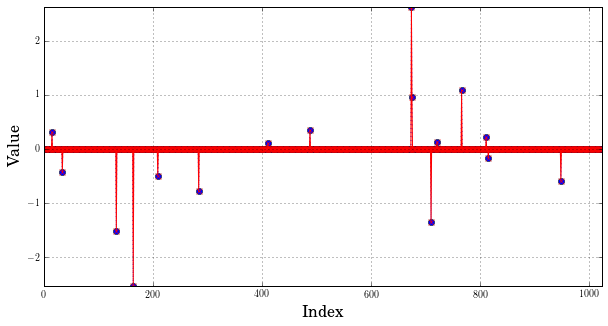

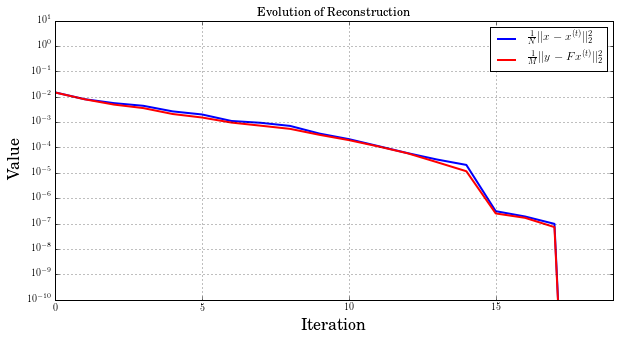

In [11]:
myxomp,Support,ompmse,ompres = OrthogonalMatchingPursuit(F,y,K,x)

ShowRecovery(x,myxomp)
ShowHistory(ompmse,ompres)

## Compressive Sampling Matching Pursuit (CoSaMP)
---

The CoSaMP approach is very similar to the original OMP approach we have just discussed. It too seekes to solve the same $\ell_0$ regularized optimization problem as the IHT and OMP algorithms. 

As this approach is at its core a _Matching Pursuit_, the CoSaMP algorithm also retains a list of supports which are updated at each iteration. This support list is refined at each iteration, again, by looking at the difference $r^{(t)} = y - F x^{(t)}$. 

However, rather than add a single support at each iteartion, CoSaMP mixes the ideas $K$-Thresholding with a Matching Pursuit approach, retaining $K$ non-zeros at each iteration.

At the beginning of every CoSaMP iteration, $2K$ possible support values are allowed. These possible locations are merged with the list at this time step, and this merged support list is used to form the on-support subproblem, much like OMP.

Finally, after solving this reduced LSQ problem, the result is then thresholded to the top $K$ coefficeints, these $K$ coefficients are taken as the final support list for the iteration, and the process is repeated.


---
- D. Needell and J. Tropp, "CoSaMP: Iterative Signal Recovery from Incomplete and Inaccurate Samples," _Applied and Computational Harmonic Analysis_, vol. 26, no. 3, pg. 301-321, 2009.

In [12]:
def CompSampMatchingPursuit(F,y,K, iters,xtrue):
    """ Use the CoSaMP alorithm to reconstruct a sparse signal.
    
        Attempt to solve the inverse problem
        
                    y = F x
        
        for known y, F, and unknown K-sparse x.
                
    
        Inputs
        -----
        F: array_like, float
           An (M,N) projection matrix
        y: array_like, float
           A vector of observations
        iters: int
               Number of iterations to perform
        xtrue: array_like, float
               Original signal, used to track MSE progress
               
        Returns
        -------
        x: array_like, float
           Recovered K-sparse signal
        Support: array_like, int
                List of support locations
        mseval: array_like, float
                The MSE against ``xtrue`` at each iteration
        resval: array_like, float
                The MSE between ``y`` and the estimate ``F x`` at each
                iteration.        
    """
    m,n = np.shape(F)                        # Obtain problem dimensions
    r = y                                    # Initialize ``r`` to ``y``
    S = np.empty((0,1),dtype=int)            # Start with an empty support list
    mseval = np.zeros((iters,1))             # Initialize array for MSE values
    resval = np.zeros((iters,1))             # Initialize array for Residual values
    
    for t in range(0,iters):                 # Loop over the number of iterations
        ## Form Signal Proxy
        q = np.dot(F.T,r)                    # Find q = F^T r, the gradient in Real^N
        ## Identify large components
        O = KSparseApproximation(q,2*K)[1]   #  Identify the locations of the 2K largest
                                             #    magnitudes in the gradient.
        ## Merge Supports (Union)
        T = np.append(O,S)                   # Merge these 2K locations into the support list
        T = np.unique(T)                     # Remove duplicates
        ## Solve reduced system
        b = np.zeros((n,1))                  # Initialize LSQ solution to zeros
        b[T] = la.lstsq(F[:,T],y)[0]         # Solve over-determined on-support LSQ problem
        ## Prune approximation
        x,S = KSparseApproximation(b,K)      # Prune out all but the top $K$ magnitude coefficients
                                             #     from the previous LSQ solution.
        ## Update residual 
        r = y - np.dot(F,x)                  # Update r = y - F x        
        ## Measure Progress
        mseval[t]   = MeanSquareError(xtrue,x)        # Calculate how far from the true solution we are
        resval[t] = MeanSquareError(y,np.dot(F,x))    # Calculate how far from the measurements we are
    
    return x,S,mseval,resval

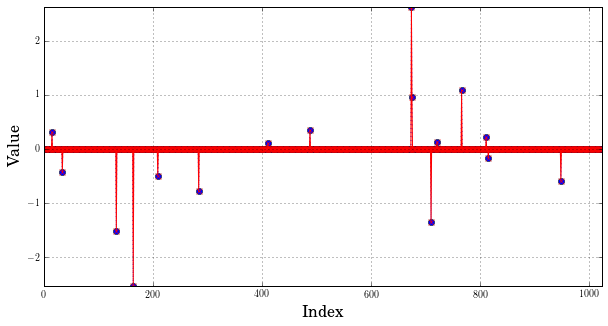

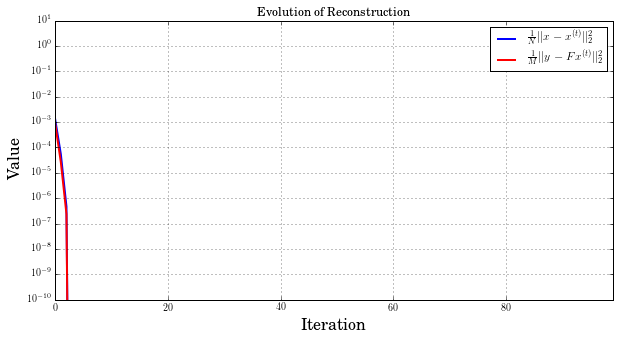

In [13]:
xcosamp,Support,cosampmse,cosampres = CompSampMatchingPursuit(F,y,20,100,x)
ShowRecovery(x,xcosamp)
ShowHistory(cosampmse,cosampres)

## L1 Minimization (Lasso)
---

One can also attempt, instead, to solve the $\ell_1$ regularized minimization problem
$$\arg\min_x\quad ||y-F x||_2^2 + \lambda ||x||_1,$$
which is commonly known as the "Lasso". One can write a mapping between the Lasso and other $\ell_1$ penalized problems such as basis-pursuit denoising. So, we'll focus on attempting to solve this unconstrained optimization problem.

The details of implementations of solvers for these kinds of problems are a little bit beyond the scope of this notebook, so we will rely on external packages to solve the Lasso problem. For example, `sckit-learn` already includes functions to solve the Lasso by a number of different methods. Below, we show how to use the Least Angle Regression (LARS) method to solve the Lasso, and thus, the $\ell_1$ minimization problem for estimating sparse $x$ given $F$ and $y$.

**Note:** Since we do not have access to the inner-workings of this algorithm, we cannot display the same historical progress of the MSE over the reconstruction iterations.

In [14]:
def L1Minimization(F,y,lam=1):
    return lm.LassoLars(alpha=lam).fit(F,y).coef_

Lars-Lasso MSE: 4.4158e-09


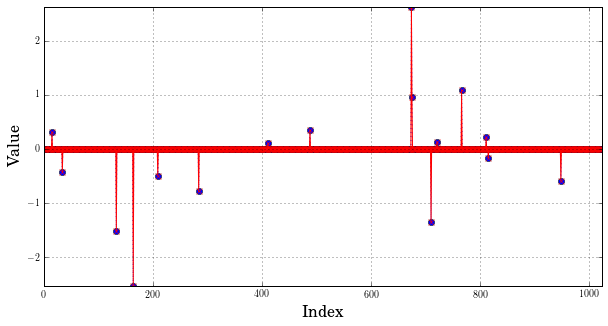

In [15]:
xl1 = L1Minimization(F,y,0.000001)
xl1 = np.reshape(xl1,(N,1))

ShowRecovery(x,xl1)
print "Lars-Lasso MSE: %0.4e" % MeanSquareError(x,xl1)

## Comparison
---

In [125]:
def RandomCompressibleSignal(alpha,N):
    x=lomax.rvs(c=alpha,size=(N,1))

    x = x / la.norm(x)

    signs = np.random.rand(N,1) > 0.5
    x[signs] = -1.0 * x[signs]
    return x

In [130]:
N = 1024     # Signal dimensionality
K = 20      # Number of non-zeros. Used both to
             #    generate the signal as well as 
             #    a parameter for the algorithms
             #    (oracle parameter setting).

## Generate a truly sparse signal
# x = RandomKSparseSignal(K,N)[0]
## Generate a Random Compressible signal
DecayStrength = 1.0
x = RandomCompressibleSignal(DecayStrength,N)

MToTest = range(2,786)[::32]
Nexp = np.size(MToTest)

mse_iht = np.zeros((Nexp,1))
mse_omp = np.zeros((Nexp,1))
mse_cosamp = np.zeros((Nexp,1))
mse_l1 = np.zeros((Nexp,1))

i = 0
for m in MToTest:
    print "Testing M = %d" % m
    F = RandomOrthoProjection(m,N)
    y = np.dot(F,x)
    
    xiht = IterativeHardThresholding(F,y,K,500,x)[0]
    xomp = OrthogonalMatchingPursuit(F,y,K,x)[0]
    xcosamp = CompSampMatchingPursuit(F,y,K,500,x)[0]
    xl1 = L1Minimization(F,y,0.000001)
    
    
    xiht = np.reshape(xiht,(N,1))
    xomp = np.reshape(xomp,(N,1))
    xcosamp = np.reshape(xcosamp,(N,1))
    xl1 = np.reshape(xl1,(N,1))
    
    mse_iht[i] = MeanSquareError(x,xiht)
    mse_omp[i] = MeanSquareError(x,xomp)
    mse_cosamp[i] = MeanSquareError(x,xcosamp)
    mse_l1[i] = MeanSquareError(x,xl1)   
    
    i = i + 1

Testing M = 2
Testing M = 34
Testing M = 66
Testing M = 98
Testing M = 130
Testing M = 162
Testing M = 194
Testing M = 226
Testing M = 258
Testing M = 290
Testing M = 322
Testing M = 354
Testing M = 386
Testing M = 418
Testing M = 450
Testing M = 482
Testing M = 514
Testing M = 546
Testing M = 578
Testing M = 610
Testing M = 642
Testing M = 674
Testing M = 706
Testing M = 738
Testing M = 770


/Users/eric/anaconda/lib/python2.7/site-packages/sklearn/linear_model/least_angle.py:285: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 1 iterations, i.e. alpha=4.631e-04, with an active set of 1 regressors, and the smallest cholesky pivot element being 2.220e-16
  ConvergenceWarning)
/Users/eric/anaconda/lib/python2.7/site-packages/sklearn/linear_model/least_angle.py:285: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 1 iterations, i.e. alpha=4.631e-04, with an active set of 1 regressors, and the smallest cholesky pivot element being 2.107e-08
  ConvergenceWarning)
/Users/eric/anaconda/lib/python2.7/site-packages/sklearn/linear_model/least_angle.py:285: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 1 iterations, i.e. alpha=4.631e-04, with an active set of 1 regressors, and the smallest cholesky pivot element being 1.490e-08
  ConvergenceWarning)


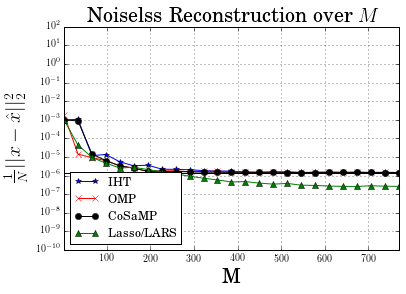

In [131]:
xk = KSparseApproximation(x,K)[0]
xkmse = MeanSquareError(x,xk)

plt.plot(MToTest,xkmse*np.ones(np.shape(MToTest)),'-k')
plt.plot(MToTest,mse_iht,'-*b',linewidth=1,label="IHT")
plt.plot(MToTest,mse_omp,'-xr',linewidth=1,label="OMP")
plt.plot(MToTest,mse_cosamp,'-ok',linewidth=1,label="CoSaMP")
plt.plot(MToTest,mse_l1,'-^g',linewidth=1,label="Lasso/LARS")
plt.yscale('log')
plt.xlabel("M",fontsize=20)
plt.grid(True)
plt.axis('tight')
plt.ylabel("$\\frac{1}{N}||x - \hat{x}||_2^2$",fontsize=20)
plt.legend(loc=3)
plt.ylim((1e-10,1e2))
plt.title("Noiselss Reconstruction over $M$",fontsize=20);